# Sine Wave Predictor

This notebook is a very simple recurrent neural net using tensorflow to predict the next value/values of a sine wave

In [1]:
# Import dependancies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt, pylab

In [2]:
# set the size of the state
state_size = 4
# set the number of lines to learn in parallel
# in this case we are just looking at one sine wave 
batch_size = 1

iterations = 25000
learning_rate = 0.05

# number of steps to predict into the future
steps_to_predict = 10

# length of array to be inputted, must be >= steps_to_predict
truncated_backprop_length = 20

# total size of training data series
# this calculation will return an array the exact size required
total_series_length = iterations+truncated_backprop_length+steps_to_predict

In [3]:
# function to generate training data
def generate_data(length):
    
    # create x data for line with max value of length
    # it increases by 0.1 each step
    x = np.linspace(0,length, length*10+1)
    # create y data for line by applying numpy's sin function to x data
    # we reshape it to a 2d array but keeping the data on one row
    y = np.sin(x).reshape(1,-1)
    
    # return the y data
    return(y)

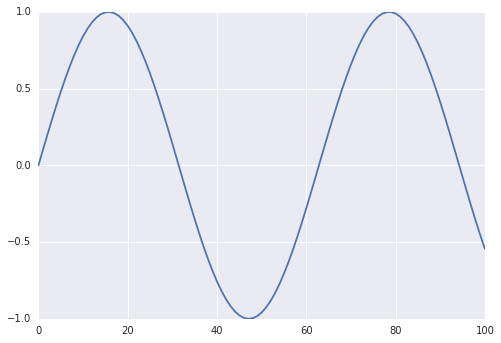

In [4]:
# plot example data
# generate data going up to 10, in 101 steps
line_data = generate_data(10)
fig, ax = plt.subplots()
# plot data but reshape to a 1d array
ax.plot(line_data.reshape(-1))
ax.grid(True)
# show plot
plt.show()

In [5]:
# create placeholders for input data and labels
# we are inputting a set of points and getting back the same number of points 
# the values are steps_to_predict number of steps ahead
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

# create an initial state placeholder
init_state = tf.placeholder(dtype=tf.float32, shape=[batch_size, state_size])

# create Weights and a bias for applying to the output of the RNN cell
W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

# split the input and label array into single arrays
inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
labels_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchY_placeholder)

In [6]:
# create RNN cell using tensorflows BasicRNNCell function with number of units as state_size
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(state_size)
# this runs the RNN cell using our formatted input data series and our initial state
# states_series is the result from the RNN cell which is the same shape as the input data
# the current data is the updated state
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [7]:
# we create our final outputs by applying the weights and bias to the output series
# since we split the input data up, the output data is also split so we need to do this for every individual value
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]

# calculate loss using l2 loss as it is calculating continuous data and not classes
# again repeat this for each value in the logits series
losses = [tf.nn.l2_loss(labels - logits, name=None) for logits, labels in zip(logits_series,labels_series)]

# total the loss for all values predicted
total_loss = tf.reduce_mean(losses)

# we are using Adagrad optimizer
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [8]:
# start session and initialize variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# generate training data
x_data = generate_data(total_series_length)

# initialize a current state with zeros
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# start training loop
# start_index is going to be the first value of the batch in this iteration
for start_index in range(iterations):

    # set the end index to the last value inthe batch of this iteration
    end_index = start_index + truncated_backprop_length

    # select input data and labels for current batch
    # the input data is selected using the start and end index
    batchX = x_data[:,start_index:end_index]
    # the labels data is selected from the start and end index but steps_to_predict number of steps ahead
    batchY = x_data[:,start_index+steps_to_predict:end_index+steps_to_predict]

    # run the training step feeding in the selected data and the current state
    # return the total_loss to print
    # return the train_step to run the optimizer
    # return the current state to update it to the next state
    _total_loss, _train_step, _current_state = sess.run([total_loss, train_step, current_state],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })
    
    # print the index and loss 20 times in total
    if (start_index)%(iterations/20) == 0:
        print 'Step',start_index, 'Loss =', _total_loss
        
# print when training has finished
print 'Done Training'

Step 0 Loss = 1.03206
Step 1250 Loss = 0.114019
Step 2500 Loss = 0.0508064
Step 3750 Loss = 0.0693702
Step 5000 Loss = 0.106803
Step 6250 Loss = 0.067319
Step 7500 Loss = 0.0214393
Step 8750 Loss = 0.0174598
Step 10000 Loss = 0.0699202
Step 11250 Loss = 0.103123
Step 12500 Loss = 0.161428
Step 13750 Loss = 0.0921573
Step 15000 Loss = 0.101057
Step 16250 Loss = 0.0900344
Step 17500 Loss = 0.110799
Step 18750 Loss = 0.038083
Step 20000 Loss = 0.0296
Step 21250 Loss = 0.0562623
Step 22500 Loss = 0.0702285
Step 23750 Loss = 0.128987
Done Training


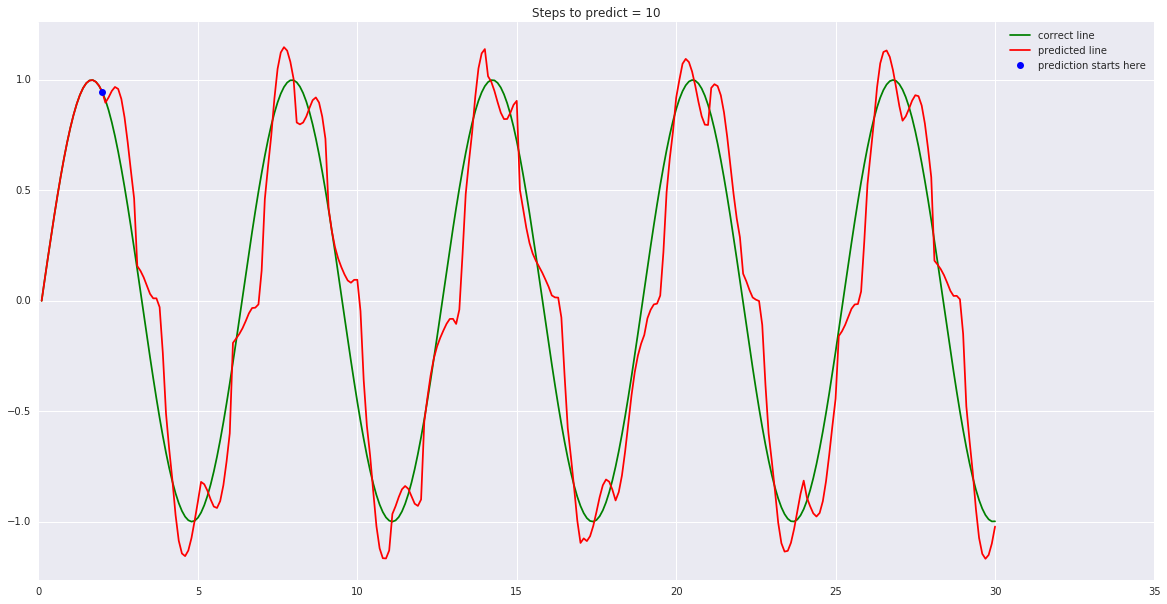

In [9]:
# initialize pred, Y and X arrays as empty
pred = Y = X = np.array([])

# initialize current state for testing
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# this will be our x values 
n = 0

# loop for 300 steps
for i in range(300):
    
    # Y will be the correct line so we will apply the sin function to it
    Y = np.append(Y, np.sin(n)).reshape(1,-1)
    
    # if we haven't got enough points to use as input data
    # dont run the prediction and use the real line instead
    if i < truncated_backprop_length:
        pred = np.append(pred, Y[:,-1])
        
    # when we have enough previous points to use as input data, run the prediction
    # also only run it when it is a multiple of steps to predict since it started making predictions
    # this is so it doesnt predict the same points multiple times
    elif i >= truncated_backprop_length and (i-truncated_backprop_length) % steps_to_predict == 0:
        
        # set previous, which is our input data, to the last truncated_backprop_length number of points from the real line
        previous = np.array(Y[:,-(truncated_backprop_length+1):-1])
        
        # append to pred with the predicted value/values
        # it runs the  output series and only picks the points that have been predicted
        # it ignores the values which were also in the input
        pred = np.append(pred, sess.run(
                [logits_series[-(steps_to_predict):truncated_backprop_length]],
                feed_dict={
                    batchX_placeholder:previous,   # input previous
                    init_state:_current_state      # use current state as state
                }))
        
        
        # update the current state
        _current_state = sess.run(current_state, feed_dict={batchX_placeholder:previous, init_state:_current_state})
        
    # increase the steps by 0.1
    n+= 0.1
    # append X array with current step
    X = np.append(X, n)

# reshape Y to a 1d array 
Y = Y.reshape([-1])

# set up plot
plt.figure(figsize=(20,10))
plt.subplot()
plt.grid(True)
plt.title('Steps to predict = %i' % steps_to_predict)

# plot the correct line, Y
plt.plot(X,Y, 'g', label='correct line')

# sometimes, the predictions go beyond the real line so we cut them off
pred = pred[0:Y.size]

# plot the  predicted line
plt.plot(X,pred, 'r', label='predicted line')
# plot the point where the prediction starts
plt.plot(X[truncated_backprop_length-1], pred[truncated_backprop_length-1], 'bo', label='prediction starts here')

# set up more of the plot
plt.legend()
pylab.ylim([-1.1*np.max(pred),1.1*np.max(pred)])
# show the plot
plt.show()